In [1]:
%matplotlib inline
import forestci as fci
from matplotlib import pyplot as plt
import pandas as pd
import os
import numpy as np
import sklearn.cross_validation as xval
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

DATAPATH = '../data'
dataset = pd.read_csv(os.path.join(DATAPATH, "autosomal_perlocus_train_intergenic.bed.gz"), sep="\t").drop_duplicates()
dataset['period'] = dataset['motif'].str.len()
features = ['uninterrupted_length', 'length','period','recomb','gc','entropy','reptiming']

In [2]:
dataset.head()

,chrom,start,end,ml_mu,ml_beta,ml_p,ml_mu_stderr,numsamples,strfilter,motif,length,uninterrupted_length,recomb,gc,entropy,reptiming,featurefilter,period
0,1,6240216,6240230,-7.673910,0.173510,0.999827,46.962810,276,PASS,C,15,15,0.179823,0.76,1.775127,1.624147,False,1
2,1,6242999,6243010,-5.919316,0.309188,0.700034,1.624597,301,PASS,A,12,12,0.179823,0.48,1.979462,1.627233,False,1
4,1,6261638,6261657,-6.801359,0.155284,0.999998,2.420272,297,PASS,AAAAC,20,20,6.985400,0.52,1.981485,1.641989,False,5
6,1,6262655,6262669,-7.674328,0.407779,0.826899,0.000000,297,PASS,AAAT,15,15,6.985400,0.57,1.943314,1.641989,False,4
8,1,6263398,6263418,-7.674330,0.062093,0.957393,0.000000,300,PASS,AATG,21,11,1.181490,0.45,1.969031,1.642892,False,4


# Unbalanced data

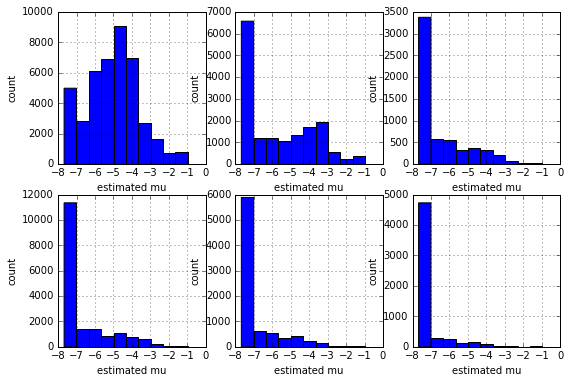

In [3]:
fig, ((axis1, axis2, axis3), (axis4, axis5, axis6)) = plt.subplots(2, 3, figsize=(9, 6))
for i in range(1, 7):
    axes = [axis1, axis2, axis3, axis4, axis5, axis6]
    ax = axes[i-1]
    dataset[dataset['period']==i]['ml_mu'].hist(ax=ax)
    ax.set_xlabel('estimated mu')
    ax.set_ylabel('count')

# get_dummies
**add dummies has been proved to be not very effective, so skip**

In [ ]:
dummies  = pd.get_dummies(dataset['motif'])
dataset = dataset.join(dummies)
dataset.shape
dataset.head()

In [ ]:
features = dataset.columns - ['chrom', 'start', 'end', 'ml_mu', 'ml_beta', 'ml_p', 'ml_mu_stderr', 'numsamples', 'strfilter', 'motif', 'featurefilter']

# Filter to things with length >= 20, period is di, tri, or tetra

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


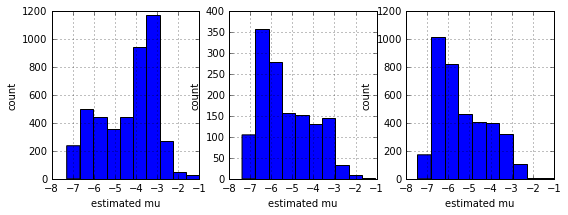

In [4]:
dataset = dataset[(dataset["length"] >= 20) & (dataset["period"].apply(lambda x: x in [2,3,4]))]
dataset = dataset[~dataset["featurefilter"]]
dataset = dataset[dataset['ml_mu'] > -7.5][dataset['ml_mu'] < -1] # Remove things at the optimization boundaries for mu
dataset = dataset[dataset['ml_beta'] < 0.899][dataset["ml_beta"] > 0.001] # Remove things at the optimization boundaries 

fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(9, 3))
for i in range(2, 5):
    axes = [axis1, axis2, axis3]
    ax = axes[i-2]
    dataset[dataset['period']==i]['ml_mu'].hist(ax=ax)
    ax.set_xlabel('estimated mu')
    ax.set_ylabel('count')

In [5]:
basic_X = dataset[features]
basic_y = dataset['ml_mu']
train_X, test_X, train_y, test_y = xval.train_test_split(basic_X, basic_y, test_size=0.25)

# Linear Regression

0.583703817781
(0.76443407834105426, 0.0)


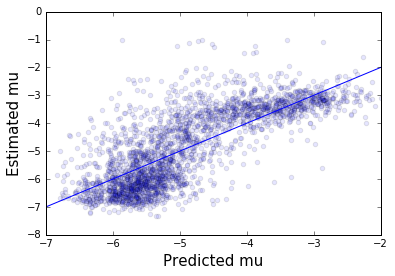

In [6]:
lr = LinearRegression()
lr.fit(train_X, train_y)
print lr.score(test_X, test_y)
plt.scatter(lr.predict(test_X), test_y, alpha=0.1)
plt.plot([-7, -2],[-7,-2])
plt.xlim(left=-7, right=-2)
plt.xlabel("Predicted mu", size=15)
plt.ylabel("Estimated mu", size=15)
print pearsonr(test_y, lr.predict(test_X))

# Random Forest

In [ ]:
rf = RandomForestRegressor(max_depth=50, min_samples_leaf=10, n_estimators=10)
# weights = np.array([0.1 if mu < -5 else 1 for mu in train_X['period']])
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)
plt.scatter(pred_y, test_y, alpha=0.1)
plt.plot([-7, -2],[-7,-2])
plt.xlim(-7, -2)
plt.ylim(-7, -2)
plt.xlabel("Predicted mu", size=15)
plt.ylabel("Estimated mu", size=15)
plt.show()
print rf.score(test_X, test_y)
print pearsonr(test_y, pred_y)

In [ ]:
rf.feature_importances_

# Compare models

In [ ]:
plt.scatter(lr.predict(test_X), rf.predict(test_X), alpha=0.1)
plt.xlabel("Linear regression prediction", size=15)
plt.ylabel("Random forest prediction", size=15)
plt.plot([-5.5, -2],[-5.5,-2])
plt.xlim(left=-5.5, right=-2)
plt.plot()

# Save predictions

In [ ]:
dataset = pd.read_csv(os.path.join(DATAPATH, "autosomal_perlocus_observed.bed.gz"), sep="\t").drop_duplicates()
dataset['period'] = dataset['motif'].str.len()
dataset['pred_mu'] = rf.predict(dataset[features])
header = ['chrom','start','end','ml_mu','ml_beta','ml_p','ml_mu_stderr','numsamples','strfilter','motif',
          'length','uninterrupted_length','recomb','gc,entropy','reptiming','featurefilter','period','pred_mu','pred_mu_se']

In [ ]:
# calculate inbag and unbiased variance
#all_X = dataset[features]
#inbag = fci.calc_inbag(train_X.shape[0], rf)
#unbiased = fci.random_forest_error(rf, inbag, train_X, all_X)
#dataset['pred_mu_se'] = np.sqrt(unbiased)

In [ ]:
dataset.to_csv(os.path.join(DATAPATH, 'alex_rough_mu_prediction.csv'), columns=header, index=False)
dataset.head()